In [6]:
import h5py
import pandas as pd
import numpy as np

from configs import * 
import os
from itertools import chain, combinations


import importlib
import data_validation_experiments



In [19]:
test_set_vars_path = "/media/big/nbbwang/AD_Project/analyses/MTL_variable_tasks/test_set_variances.csv"


with h5py.File("%s%s/%s.h5"%(path_to_MDAD_data_folders, SPECIFIC_FOLDER, full_pca_dataset)) as hf:
    labels_names = hf["labels_names"][:]
    labels = hf["labels"][:]
    labels_df = pd.DataFrame(labels, columns=labels_names.astype(str))


In [20]:

def powerset(seq):
    """
    Returns all the subsets of this set. This is a generator.
    """
    if len(seq) <= 1:
        yield seq
        yield []
    else:
        for item in powerset(seq[1:]):
            yield [seq[0]]+item
            yield item

In [21]:
train_datasets = ["ACT.tsv", "MSBB_RNA.tsv", "ROSMAP_GE1.tsv"]
test_datasets = ["ROSMAP_GE1.tsv"]

def short_subset_name(subset):
    short_names = {"ACT.tsv": "A", "ROSMAP_GE1.tsv": "R", "MSBB_RNA.tsv": "M"}
    short_name = ""
    for item in subset:
        short_name += short_names[item]
    return short_name

In [22]:
folds = range(25, 30)
subsets = powerset(train_datasets)

In [8]:
from models import linear_baseline

variances = pd.read_csv(test_set_vars_path)
results_for_fold = {}

linear_results_df = pd.DataFrame(columns=['Val', 'Phenotype', 'Fold', 'Subset'])

for fold in folds:
    print(fold)
    for phenotype in ["CERAD", "PLAQUES", "ABETA_IHC", "BRAAK", "TANGLES", "TAU_IHC"]:
        print(phenotype)
        for subset in powerset(train_datasets):
            if not subset:
                continue
            importlib.reload(data_validation_experiments)
            test = data_validation_experiments.DataValidationExperiment(fold, subset, test_datasets)
            X_train, X_valid, y_train, y_valid = test.load_data_for_fold(fold)
            
            indices_to_keep = np.where(np.isfinite(y_train[phenotype]))
            X_train = X_train[indices_to_keep]
            y_train[phenotype] = y_train[phenotype][indices_to_keep]
            if X_train.shape[0] > 0:
                
                indices_to_keep = np.where(np.isfinite(y_valid[phenotype]))
                X_valid = X_valid[indices_to_keep]
                y_valid[phenotype] = y_valid[phenotype][indices_to_keep]
                
                model = linear_baseline(
                    X_train, 
                    {
                        "learning_rate": 0.0001,
                        "k_reg": 0.001,
                        "grad_clip_norm": 0.1
                    })
                model.fit(x={'main_input': X_train},
                                y={'out': y_train[phenotype]}, 
                      validation_data = ({'main_input': X_valid}, 
                                         {'out' :y_valid[phenotype]}),                                     
                      verbose=0,epochs=200, batch_size=20)

                predictions = model.predict(X_valid)
                mse = ((predictions - y_valid[phenotype])**2).mean()
                mse /= variances.iloc[fold][phenotype]
            else:
                mse = 0
            #set_trace()
            linear_results_df = linear_results_df.append({
                "Val": mse, "Phenotype": phenotype, "Fold": fold, "Subset": short_subset_name(subset)
            }, ignore_index=True)
                

25
CERAD


W0319 11:26:18.842026 140616015603520 deprecation_wrapper.py:119] From /homes/gws/ewein/ad_replication/processed/combined_files/Code/models.py:13: The name tf.is_finite is deprecated. Please use tf.math.is_finite instead.

W0319 11:26:18.858362 140616015603520 deprecation.py:323] From /homes/gws/ewein/.local/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0319 11:26:19.174818 140616015603520 deprecation_wrapper.py:119] From /homes/gws/ewein/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



PLAQUES
ABETA_IHC
BRAAK
TANGLES
TAU_IHC
26
CERAD
PLAQUES
ABETA_IHC
BRAAK
TANGLES
TAU_IHC
27
CERAD
PLAQUES
ABETA_IHC
BRAAK
TANGLES
TAU_IHC
28
CERAD
PLAQUES
ABETA_IHC
BRAAK
TANGLES
TAU_IHC
29
CERAD
PLAQUES
ABETA_IHC
BRAAK
TANGLES
TAU_IHC


In [10]:
mean_linear_results_df = linear_results_df.groupby(['Phenotype', "Subset"]).mean()

In [43]:
sem_linear_results_df = linear_results_df.groupby(['Phenotype', 'Subset']).sem().drop('Fold', axis=1)

              Val
Subset           
A        8.442552
M        0.000000
R        1.612100
AM      14.907694
AR       1.373224
MR       1.546417
AMR      1.368964
             Val
Subset          
A       2.658150
M       0.000000
R       0.058730
AM      1.954539
AR      0.046713
MR      0.083097
AMR     0.044104
              Val
Subset           
A       10.560341
M        7.326908
R        1.989243
AM       5.791362
AR       1.084137
MR       1.070370
AMR      1.032321
             Val
Subset          
A       2.126719
M       1.384412
R       0.100238
AM      1.024040
AR      0.061083
MR      0.037400
AMR     0.038567
             Val
Subset          
A       3.829335
M       3.427278
R       1.425281
AM      4.303371
AR      1.212725
MR      1.305731
AMR     1.232760
             Val
Subset          
A       0.858662
M       0.235643
R       0.032887
AM      1.126316
AR      0.032415
MR      0.031223
AMR     0.023950
             Val
Subset          
A       0.000000
M       7.019

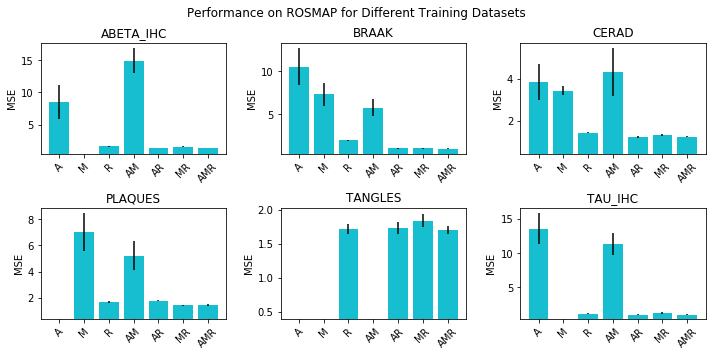

In [48]:
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

import matplotlib

cmap = matplotlib.cm.get_cmap('tab20')
baseline_color = cmap(18)

phenotypes = ["ABETA_IHC", "BRAAK", "CERAD", "PLAQUES", "TANGLES", "TAU_IHC"]

dataset_size_rank = {
    "A": 337,
    "M": 879,
    "R": 542,
    "AM": 337+879,
    "AR": 337+542+1, #AR has same size as M (add 1 here to force it displayed after M)
    "MR": 879+542,
    "AMR": 337+879+542
}

keys_in_size_order = [
    "A", "M", "R", "AM", "AR", "MR", "AMR"
]

nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(10,5))

for i, phenotype in enumerate(phenotypes):
    col = i % ncols
    row = i // ncols 
    
    vals = mean_linear_results_df.loc[phenotype]
    vals = vals.reindex(dataset_size_rank.keys())
    
    sems = sem_linear_results_df.loc[phenotype]
    sems = sems.reindex(dataset_size_rank.keys())
    
    ax = axes[row, col]
    
    ax.bar(dataset_size_rank.keys(), vals.values.squeeze(), color=baseline_color, yerr=sems['Val'])
    ax.set_xticklabels(dataset_size_rank.keys(), rotation=45)
    ax.set_ylabel("MSE")
    ax.set_ylim(bottom=0.4)
    ax.set_title("{}".format(phenotype))
    
fig.suptitle("Performance on ROSMAP for Different Training Datasets")
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [15]:
datasets_to_phenotypes = {
    "A": ["ABETA_IHC", "TAU_IHC", "CERAD", "BRAAK"],
    "R": ["ABETA_IHC", "BRAAK", "CERAD", "PLAQUES", "TANGLES", "TAU_IHC"],
    "M": ["PLAQUES", "CERAD", "BRAAK"]
}

def phenotype_in_subset(phenotype, subset):
    for dataset in subset:
        if phenotype in datasets_to_phenotypes[dataset]:
            return True
    return False

In [17]:
import pandas as pd
variances = pd.read_csv("test_set_variances.csv")
subset_to_results = {}
folds = range(25, 30)

def get_final_results(subset, fold_idx):
    subset_results = pd.read_csv(
        "/homes/gws/ewein/ad_replication/processed/combined_files/Code/MODEL_OUTPUTS/results/md-ad_data_validation/ACT_MSBBRNA_ROSMAP_PCASplit/" + str(subset) + "/" + str(fold_idx) + ".log"
    )
    filter_cols = [col for col in subset_results if col.startswith("val")]
    subset_results = subset_results[filter_cols]
    final_subset_results = subset_results.iloc[199]
    return final_subset_results

subsets = powerset(train_datasets)
mlp_results_df = pd.DataFrame(columns=['Val', 'Phenotype', 'Fold', 'Subset'])

for fold in folds:
    print(fold)
    for phenotype in ["CERAD", "PLAQUES", "ABETA_IHC", "BRAAK", "TANGLES", "TAU_IHC"]:
        print(phenotype)
        for subset in powerset(train_datasets):
            if not subset:
                continue
            final_subset_results_for_fold = get_final_results(subset, fold)
            val = final_subset_results_for_fold["val_{}_out_loss".format(phenotype)] / variances.iloc[fold][phenotype] if phenotype_in_subset(phenotype, short_subset_name(subset)) else 0
            
            mlp_results_df = mlp_results_df.append({
                "Val": val,
                "Phenotype": phenotype,
                "Fold": fold,
                "Subset": short_subset_name(subset)
            }, ignore_index=True)

25
CERAD
PLAQUES
ABETA_IHC
BRAAK
TANGLES
TAU_IHC
26
CERAD
PLAQUES
ABETA_IHC
BRAAK
TANGLES
TAU_IHC
27
CERAD
PLAQUES
ABETA_IHC
BRAAK
TANGLES
TAU_IHC
28
CERAD
PLAQUES
ABETA_IHC
BRAAK
TANGLES
TAU_IHC
29
CERAD
PLAQUES
ABETA_IHC
BRAAK
TANGLES
TAU_IHC


In [28]:
pickle.dump(mlp_results_df, open("md_ad_results_nicasia_corrected.p", "wb"))

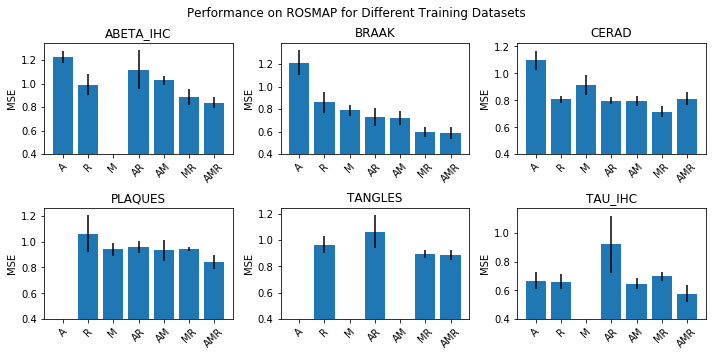

In [27]:
from scipy.stats import sem

import matplotlib.pyplot as plt

phenotypes = ["ABETA_IHC", "BRAAK", "CERAD", "PLAQUES", "TANGLES", "TAU_IHC"]
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(10,5))

dataset_size_rank = {
    "A": 337,
    "M": 879,
    "R": 542,
    "AM": 337+879,
    "AR": 337+542+1, #AR has same size as M (add 1 here to force it displayed after M)
    "MR": 879+542,
    "AMR": 337+879+542
}

for i, phenotype in enumerate(phenotypes):
    col = i % ncols
    row = i // ncols 
    
    vals = [value["val_{}_out_loss".format(phenotype)].mean() if phenotype_in_subset(phenotype, key) else 0 for (key, value) in subset_to_results.items()]
    stderrs = [sem(value["val_{}_out_loss".format(phenotype)]) if phenotype_in_subset(phenotype, key) else 0 for (key, value) in subset_to_results.items()]
    keys = [key for key in subset_to_results.keys()]
    
    ax = axes[row, col]
    
    sorted_keys_and_vals = sorted(
        zip(keys, vals, stderrs), key=lambda x: dataset_size_rank[x[0]]
    )
    sorted_keys = [key_and_val[0] for key_and_val in sorted_keys_and_vals]
    sorted_vals = [key_and_val[1] for key_and_val in sorted_keys_and_vals]
    sorted_stderrs = [key_and_val[2] for key_and_val in sorted_keys_and_vals]

    ax.bar(sorted_keys, sorted_vals, yerr=sorted_stderrs)
    ax.set_xticklabels(sorted_keys, rotation=45)
    ax.set_ylabel("MSE")
    ax.set_ylim(bottom=0.4)
    ax.set_title("{}".format(phenotype))
fig.suptitle("Performance on ROSMAP for Different Training Datasets")
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()